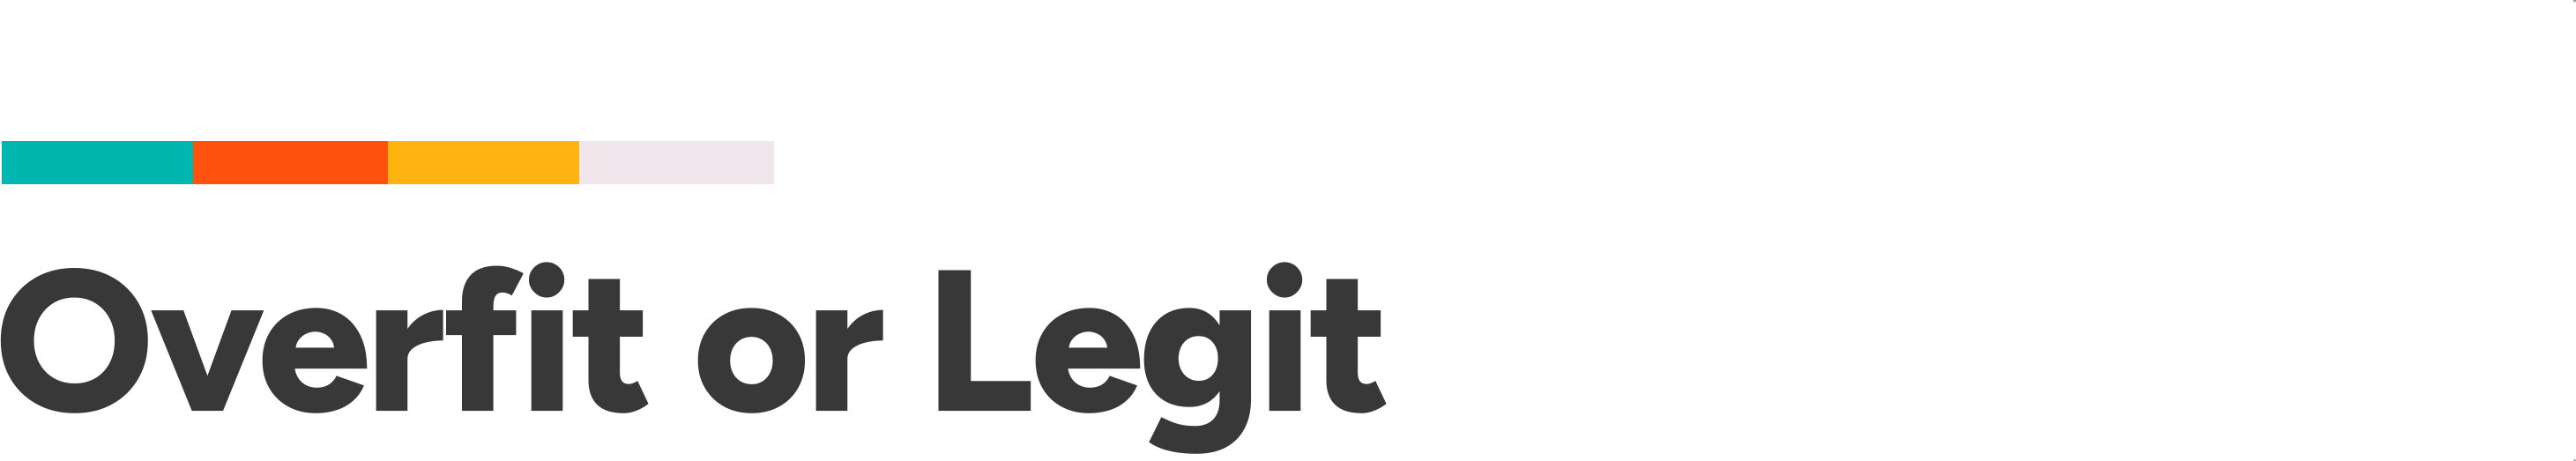

#
 
<div class="alert alert-info">

**[collapse] IMPORTING LIBRARIES AND DATA**

</div>

In [231]:
import os
import glob
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from hmmlearn import hmm
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    recall_score, precision_score, f1_score, accuracy_score, 
    classification_report, confusion_matrix, roc_curve, auc, 
    precision_recall_curve, matthews_corrcoef
)
from sklearn.preprocessing import StandardScaler
# from tpot import TPOTClassifier
import ta
from h2o.automl import H2OAutoML

sns.set_theme(style = 'darkgrid', font_scale=0.6, palette='viridis')
plt.rcParams['figure.figsize'] = (6, 3)
warnings.filterwarnings('ignore')

In [239]:
directory_path = 'forex_lite'
files = glob.glob(os.path.join(directory_path, '*.csv'))

content = []
for i in files:
    df = pd.read_csv(i, header = 0)
    content.append(df)

prices = pd.merge((pd.merge(content[0], content[1], on = 'Date', how = 'inner')), \
                  content[2], on = 'Date', how = 'inner')
prices['Date'] = pd.to_datetime(prices['Date'])
prices.set_index('Date', inplace = True)
prices_hourly = prices.resample('1H').last().ffill()
prices_daily = prices.resample('1D').last().ffill()
prices

,EURUSD,GBPUSD,USDJPY
Date,,,
2010-01-03 21:00:00,1.43235,1.61228,92.993
2010-01-03 21:05:00,1.43287,1.61261,92.933
2010-01-03 21:10:00,1.43293,1.61272,92.905
2010-01-03 21:15:00,1.43290,1.61316,92.810
2010-01-03 21:20:00,1.43304,1.61429,92.808
...,...,...,...
2024-05-07 10:30:00,1.07622,1.25373,154.574
2024-05-07 10:35:00,1.07633,1.25396,154.566
2024-05-07 10:40:00,1.07632,1.25387,154.527


#
 
<div class="alert alert-info">

**[collapse] FEATURE ENGINEERING**

</div>

for fractional differencing

In [240]:
def calculate_weights_ffd(
        degree: float,
        threshold: float
) -> np.ndarray:
    weights = [1.]
    k = 1
    while abs(weights[-1]) >= threshold:
        weight = -weights[-1] / k * (degree - k + 1)
        weights.append(weight)
        k += 1
    return np.array(weights[::-1]).reshape(-1, 1)[1:]

def fractional_difference_fixed_single(
        series: pd.Series,
        degree: float,
        threshold: float = 1e-1
) -> pd.DataFrame:
    weights = calculate_weights_ffd(degree, threshold)
    width = len(weights) - 1
    series_filtered = series.ffill().dropna()
    result_series = pd.Series(dtype="float64", index=series.index)
    for iloc in range(width, series_filtered.shape[0]):
        day1 = series_filtered.index[iloc - width]
        day2 = series_filtered.index[iloc]
        if not np.isfinite(series.loc[day2]):
            continue
        result_series[day2] = np.dot(weights.T, series_filtered.loc[day1:day2])[0]
    return result_series

def get_fracdiff_log_price(
    input_series: pd.Series,
    threshold=0.01,
    step=0.005,
    base_p_value=0.05
) -> float:
    log_price = np.log(input_series)
    degree = -step
    p_value = 1

    while p_value > base_p_value:
        degree += step
        differentiated = fractional_difference_fixed_single(log_price, degree, threshold=threshold)
        adf_test = adfuller(differentiated.dropna(), maxlag=1, regression='c', autolag=None)
        p_value = adf_test[1]

    return differentiated

In [241]:
def create_lag_price_features(
    price: pd.DataFrame, 
    order: int = 14,
    ) -> pd.DataFrame:
    """Create lag features for close price"""
    lag_price = pd.DataFrame(index=price.index)
    for i in range(1, order + 1):
        lag_price[f'lag_{i}'] = price.shift(i)
    return lag_price

def regime_hmm(test_data: pd.Series, train_data: pd.Series, n_states: int = 2, n_iter: int = 1000) -> pd.DataFrame:
    """Apply Hidden Markov Model to detect regimes in the data and return the probabilities of each state"""
    test_data = test_data.to_frame()
    train_data = train_data.to_frame()
    
    hmm_model = hmm.GaussianHMM(n_iter=n_iter, n_components=n_states, covariance_type='full', init_params='stmc')
    hmm_model.fit(train_data)
    hmm_probs = hmm_model.predict_proba(test_data)
    
    hmm_results = pd.DataFrame(index=test_data.index)
    for state in range(n_states):
        hmm_results[f'hmm_state_{state}'] = hmm_probs[:, state]

    return hmm_results

def regime_gmm(data: pd.Series, n_states: int = 2) -> pd.DataFrame:
    """Apply Gaussian Mixture Model to detect regimes in the data and return the probabilities of each state"""
    gmm_model = GaussianMixture(n_components=n_states)
    gmm_model.fit(data.to_frame())
    gmm_probs = gmm_model.predict_proba(data.to_frame())

    gmm_results = pd.DataFrame(index=data.index)
    for state in range(n_states):
        gmm_results[f'gmm_state_{state}'] = gmm_probs[:, state]

    return gmm_results

def get_volat_w_log_returns(
    close: pd.Series,
    span: int = 100
) -> pd.Series:
    freq = pd.infer_freq(close.index).upper()
    if freq == 'D':
        time_delta = pd.Timedelta(days=1)
    elif freq == 'H':
        time_delta = pd.Timedelta(hours=1)
    else:
        raise ValueError(f"Unsupported frequency: {freq}")

    df = close.index.searchsorted(close.index - time_delta)        
    df = df[df > 0]
    df = pd.Series(close.index[df - 1], index = close.index[close.shape[0] - df.shape[0]:])
    returns = np.log(close.loc[df.index] / close.loc[df.values].values)
    stds = returns.ewm(span=span).std().rename("std")

    return stds

def generate_features(
    close: pd.Series, 
    order: int = 14,
    span: int = 5
) -> pd.DataFrame:
    """Generate various technical indicators and features from closing prices"""
    returns = close.pct_change().shift(-order)
    features = pd.DataFrame()
    features['close'] = close
    features['returns'] = returns
        
    features['frac_diff_log'] = get_fracdiff_log_price(features['close'])
    features['volat'] = get_volat_w_log_returns(features['close'], span)
    # features['sma_10'] = ta.trend.sma_indicator(close, window=10)
    # features['sma_20'] = ta.trend.sma_indicator(close, window=20)
    # features['sma_100'] = ta.trend.sma_indicator(close, window=100)
    # features['ema_10'] = ta.trend.ema_indicator(close, window=10)
    # features['ema_20'] = ta.trend.ema_indicator(close, window=20)
    # features['ema_100'] = ta.trend.ema_indicator(close, window=100)
    # features["roc_10"] = ta.momentum.roc(close, window=10, fillna=True)
    # features["roc_20"] = ta.momentum.roc(close, window=20, fillna=True)
    # features["roc_100"] = ta.momentum.roc(close, window=100, fillna=True)
    # features['bb_upper'] = ta.volatility.bollinger_hband(close)  
    # features['bb_middle'] = ta.volatility.bollinger_mavg(close)
    # features['bb_lower'] = ta.volatility.bollinger_lband(close)

    # features['rsi_10'] = ta.momentum.rsi(close, window=10, fillna=True)
    # features['rsi_20'] = ta.momentum.rsi(close, window=20, fillna=True)
    # features['rsi_100'] = ta.momentum.rsi(close, window=100, fillna=True)
    # macd_line = np.log(close.ewm(span=12).mean() / close.ewm(span=26).mean())
    # signal_line = macd_line.ewm(span=9).mean()
    # features["log_macd_hist"] = macd_line - signal_line
    # features["log_dpo"] = np.log(close.rolling(11).mean() / close.rolling(20).mean())

    # gmm_on_return = regime_gmm(features['returns'].dropna(), n_states=2)
    # features = features.join(gmm_on_return, how='left')

    lag_price = create_lag_price_features(close, order=order)
    features = features.join(lag_price)

    return features

https://github.com/letianzj/QuantResearch/blob/master/notebooks/gaussian_mixture_markov_switching.ipynb

https://letianzj.github.io/gaussian-mixture-markov-regime-switching.html

In [242]:
df_daily = generate_features(prices_daily['EURUSD'], span = 100, order = 2)
df_daily.head(2)

,close,returns,frac_diff_log,volat,lag_1,lag_2,lag_3,lag_4,lag_5
Date,,,,,,,,,
2010-01-03,1.42705,0.00682,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-04,1.44189,0.00000,NaN,NaN,1.42705,NaN,NaN,NaN,NaN


In [ ]:
df_hourly = generate_features(prices_hourly['EURUSD'], span = 100, order = 2)
df_hourly.head(2)

note: if its too stationary (i.e. way smaller than 0.05 aka differencing too much aka were losing too much memory -> decrease the step size): for a step of 0.005:
* daily: p = 0.04797044457926739
* hourly: p = 0.049993434292006735

#
 
<div class="alert alert-info">

**STRATEGY CONSTRUCTION**

</div>

In machine learning, classification models often exhibit higher accuracy than regression models [link](https://www.mdpi.com/2227-7390/12/5/780). Therefore, our research initially generates trading signals (labels) for pair trading by using the Triple Barrier Labeling Method to produce labels. Next, we use a GA to optimize these labels and then train the machine learning model with the optimized labels.

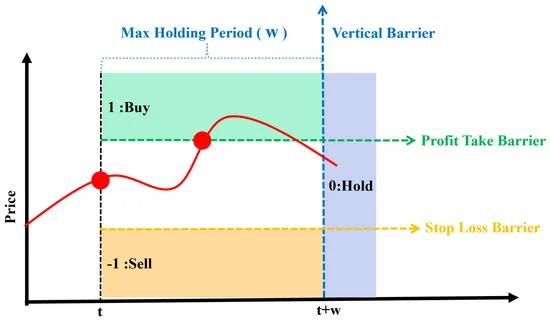

In [245]:
def vertical_barrier(
    close: pd.Series,
    events: pd.DatetimeIndex, 
    num_days: int) -> pd.Series:
    """
    get the vertical barrier (time limit) for each event:
    ------------
    > close: pd.Series - the closing prices
    > events: pd.DatetimeIndex - the dates of the events
    > num_days: int - the number of days to hold the position
    """
    timestamp_array = close.index.searchsorted(events + pd.Timedelta(days=num_days))
    timestamp_array = timestamp_array[timestamp_array < close.shape[0]]
    timestamp_array = pd.Series(close.index[timestamp_array], index=events[:timestamp_array.shape[0]])
    return timestamp_array 

def get_position(df: pd.DataFrame, ptsl: list = [1, 1], num_days: int = 10) -> pd.DataFrame:
    """
    get positions using the triple barrier method:
    > if the price hits the profit-taking level, go long (1)   
    > if the price hits the stop-loss level, go short (-1)
    > if the price hits the vertical barrier, go neutral (0) 
    > position is held until the earliest of the 3 barriers is reached    
    ------------
    > df: pd.DataFrame - the dataframe containing the features
    > ptsl: list - the profit-taking and stop-loss levels (horizontal barriers)
    > num_days: int - the number of days to hold the position (vertical barrier)
    """

    # vertical barriers
    df['vert_bars'] = vertical_barrier(df['close'], df.index, num_days) 

    # profit-taking and stop-loss levels
    pt = ptsl[0] * df['volat']
    sl = -ptsl[1] * df['volat']

    # log returns of price slice
    for location, timestamp in df['vert_bars'].items():
        segment = df.close[location:timestamp] # location = entry, timestamp = exit
        returns = np.log(segment / df.close[location])
        df.loc[location, 'stop_loss'] = returns[returns < sl[location]].index.min()
        df.loc[location, 'profit_taking'] = returns[returns > pt[location]].index.min()
        
    # end time - the earliest barrier reached out of the 3
    df['end_time'] = df[['stop_loss', 'profit_taking', 'vert_bars']].min(axis=1)
    
    df['position'] = np.where(df['end_time'] == df['profit_taking'], 1,
                              np.where(df['end_time'] == df['stop_loss'], -1, 0))

    return df

def get_labels(df: pd.DataFrame) -> pd.DataFrame:
    """
    get labels i.e. the outcome of each position:
    > 1: profit
    > 0: neutral / loss
    ------------
    > df: pd.DataFrame - dataframe containing the features & positions
    """
    df['end_close'] = df['vert_bars'].map(df['close'])
    df['profit'] = df['end_close'] / df['close'] - 1
    df['profit'] *= df['position'].shift()
    df['outcome'] = np.sign(df['profit'])
    df.loc[df['profit'] <= 0, 'outcome'] = 0
    df['outcome'].reindex(df.index)
    return df

In [169]:
def perf_metrics(daily_pnl_series, freq_day: int = 1): 
    """
    Calculate the Sharpe ratio & maximum drawdown of the daily PnL series
    """
    freq = pd.infer_freq(daily_pnl_series.index).upper()
    if freq == 'D':
        annualisation_factor = np.sqrt(252)
    elif freq == 'H':
        annualisation_factor = np.sqrt(252 * 24)
    else:
        raise ValueError(f"Unsupported frequency: {freq}")
    sharpe = daily_pnl_series.mean() / daily_pnl_series.std() * annualisation_factor 
    cum_ret = daily_pnl_series.cumsum() 
    running_max = cum_ret.cummax() 
    drawdown = running_max - cum_ret 
    max_dd = drawdown.max() 
    return sharpe, max_dd

<div class="alert alert-todo">

**IN SAMPLE**

</div>

Length of df_daily: 5239


,close,returns,vert_bars,stop_loss,profit_taking,end_time,position,end_close,profit,outcome
Date,,,,,,,,,,
2010-01-03,1.42705,0.006820,2010-01-13,NaT,NaT,2010-01-13,0,1.45360,NaN,NaN
2010-01-04,1.44189,0.000000,2010-01-14,NaT,NaT,2010-01-14,0,1.44382,0.000000,0.0
2010-01-05,1.43675,0.004948,2010-01-15,NaT,NaT,2010-01-15,0,1.43857,0.000000,0.0
2010-01-06,1.44238,0.000670,2010-01-16,2010-01-07,2010-01-10,2010-01-07,-1,1.43857,-0.000000,0.0
2010-01-07,1.43117,-0.000973,2010-01-17,NaT,2010-01-08,2010-01-08,1,1.43422,-0.002131,0.0


Sharpe: 3.7505, Max drawdown: 0.3205%


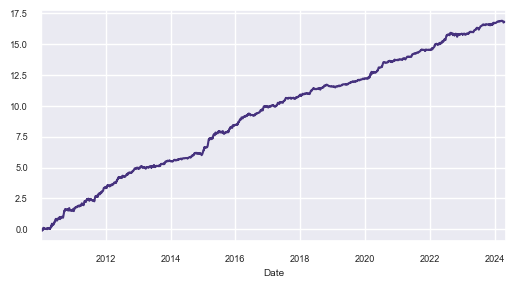

In [246]:
df_daily = get_position(df_daily, ptsl=[0.5, 0.5], num_days=10)
df_daily.isna().sum()
df_daily = get_labels(df_daily)
df_daily.dropna(subset = 'outcome')
print('Length of df_daily:', len(df_daily))
display(df_daily.iloc[:5, [0, 1] + list(range(-8, 0))])
sharpe, max_dd = perf_metrics(df_daily['profit']) 
print(f'Sharpe: {sharpe:.4f}, Max drawdown: {max_dd:.4}%')
df_daily.profit.cumsum().plot();

Length of df_hourly: 125703


,close,returns,vert_bars,stop_loss,profit_taking,end_time,position,end_close,profit,outcome
Date,,,,,,,,,,
2010-01-03 21:00:00,1.43153,0.000343,2010-01-13 21:00:00,NaT,NaT,2010-01-13 21:00:00,0,1.45223,0.000000,0.0
2010-01-03 22:00:00,1.42886,0.000749,2010-01-13 22:00:00,NaT,NaT,2010-01-13 22:00:00,0,1.45313,0.000000,0.0
2010-01-03 23:00:00,1.42705,-0.000385,2010-01-13 23:00:00,NaT,NaT,2010-01-13 23:00:00,0,1.45360,0.000000,0.0
2010-01-04 00:00:00,1.42939,0.000595,2010-01-14 00:00:00,NaT,2010-01-04 06:00:00,2010-01-04 06:00:00,1,1.45451,0.017574,1.0
2010-01-04 01:00:00,1.42848,0.002370,2010-01-14 01:00:00,NaT,2010-01-04 05:00:00,2010-01-04 05:00:00,1,1.45374,0.017683,1.0


Sharpe: 4.653908517615412, Max drawdown: 14.31403335353969


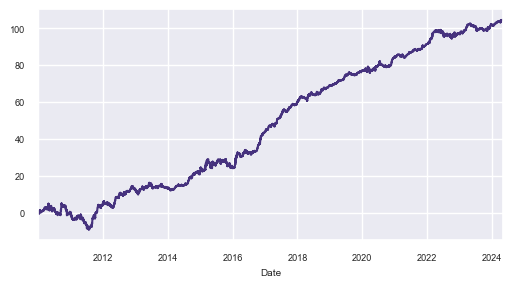

In [203]:
df_hourly = get_position(df_hourly, ptsl=[0.5, 0.5], num_days=10)
df_hourly.isna().sum()
df_hourly = get_labels(df_hourly)
df_hourly.dropna(subset = 'outcome')
print('Length of df_hourly:', len(df_hourly))
display(df_hourly.iloc[:5, [0, 1] + list(range(-8, 0))])
sharpe, max_dd = perf_metrics(df_hourly['profit']) 
print(f'Sharpe: {sharpe:.4f}, Max drawdown: {max_dd:.4}%')
df_hourly.profit.cumsum().plot();

<div class="alert alert-todo">

**OUT OF SAMPLE**

</div>

In [227]:
def out_of_sample_test(
    close: pd.DataFrame,
    train_portion: int = 0.6,
    order: int = 5,
    num_days: int = 10,
    ptsl: list = [1, 0.5],
    span = 100
):
    df = generate_features(close, span, order)

    split_index = int(len(df) * train_portion)
    test = df.iloc[split_index:]

    test = get_position(test, ptsl, num_days)
    test.isna().sum()
    test = get_labels(test)
    test.dropna(subset='outcome')
    print('Length of test:', len(test))
    display(test.iloc[:5, [0, 1] + list(range(-8, 0))])
    sharpe, max_dd = perf_metrics(test['profit'])
    print(f'OOS Sharpe: {sharpe}, OOS Max drawdown: {max_dd}')
    test.profit.cumsum().plot();

Daily data

Length of test: 2096


,close,returns,vert_bars,stop_loss,profit_taking,end_time,position,end_close,profit,outcome
Date,,,,,,,,,,
2018-08-12,1.13944,-0.007249,2018-08-22,2018-08-14,2018-08-17,2018-08-14,-1,1.15858,NaN,NaN
2018-08-13,1.14002,0.001821,2018-08-23,2018-08-14,2018-08-17,2018-08-14,-1,1.15416,-0.012403,0.0
2018-08-14,1.13463,0.001546,2018-08-24,NaT,2018-08-16,2018-08-16,1,1.16218,-0.024281,0.0
2018-08-15,1.13412,-0.006568,2018-08-25,NaT,2018-08-16,2018-08-16,1,1.16218,0.024742,1.0
2018-08-16,1.13714,0.000000,2018-08-26,NaT,2018-08-17,2018-08-17,1,1.16447,0.024034,1.0


OOS Sharpe: 2.5139405861710467, OOS Max drawdown: 0.24808167571729944


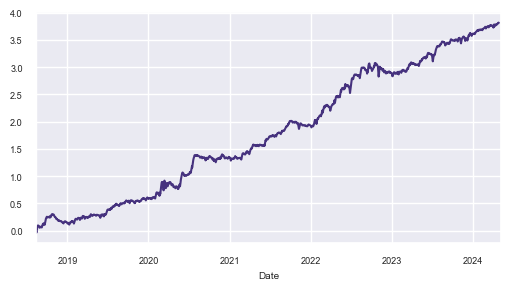

In [247]:
# EURUSD
out_of_sample_test(prices_daily.iloc[:, 0], train_portion = 0.6, order = 2, num_days = 10, ptsl = [0.5, 0.5], span = 100)

Length of test: 2096


,close,returns,vert_bars,stop_loss,profit_taking,end_time,position,end_close,profit,outcome
Date,,,,,,,,,,
2018-08-12,1.27589,-0.005104,2018-08-22,2018-08-14,2018-08-20,2018-08-14,-1,1.29053,NaN,NaN
2018-08-13,1.27584,-0.000860,2018-08-23,2018-08-14,2018-08-20,2018-08-14,-1,1.28088,-0.003950,0.0
2018-08-14,1.27172,0.007803,2018-08-24,2018-08-15,2018-08-17,2018-08-15,-1,1.28476,-0.010254,0.0
2018-08-15,1.26922,-0.005918,2018-08-25,NaT,2018-08-16,2018-08-16,1,1.28476,-0.012244,0.0
2018-08-16,1.27117,0.000000,2018-08-26,NaT,2018-08-17,2018-08-17,1,1.28573,0.011454,1.0


OOS Sharpe: 2.8799524640189063, OOS Max drawdown: 0.2730991156328344


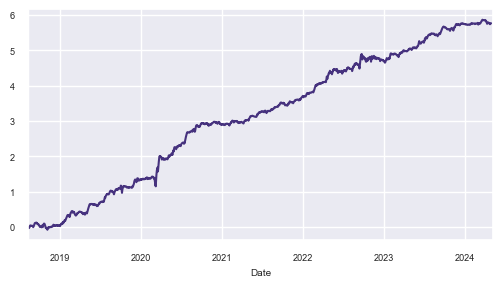

In [248]:
# GBPUSD
out_of_sample_test(prices_daily.iloc[:, 1], train_portion = 0.6, order = 2, num_days = 10, ptsl = [0.5, 0.5], span = 100)

Length of test: 2096


,close,returns,vert_bars,stop_loss,profit_taking,end_time,position,end_close,profit,outcome
Date,,,,,,,,,,
2018-08-12,110.626,0.001963,2018-08-22,2018-08-15,2018-08-14,2018-08-14,1,110.590,NaN,NaN
2018-08-13,110.626,0.002517,2018-08-23,2018-08-15,2018-08-14,2018-08-14,1,111.366,0.006689,1.0
2018-08-14,111.250,-0.000973,2018-08-24,2018-08-15,NaT,2018-08-15,-1,111.234,-0.000144,0.0
2018-08-15,110.571,-0.000451,2018-08-25,2018-08-20,2018-08-16,2018-08-16,1,111.234,-0.005996,0.0
2018-08-16,111.010,0.000000,2018-08-26,2018-08-17,2018-08-23,2018-08-17,-1,111.288,0.002504,1.0


OOS Sharpe: 2.7634209449745346, OOS Max drawdown: 0.23944630884516716


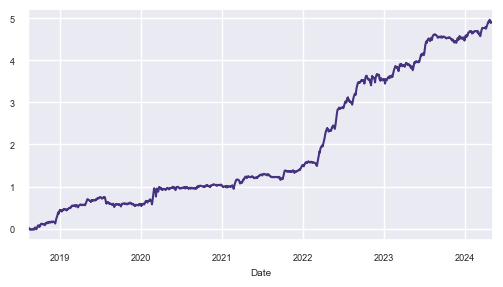

In [249]:
# USDJPY
out_of_sample_test(prices_daily.iloc[:, 2], train_portion = 0.6, order = 2, num_days = 10, ptsl = [0.5, 0.5], span = 100)

<div class="alert alert-danger">

**for daily data:      
 ~ all 3 sharpe = around 6,         
 ~ max dd < 1%**

</div>

Hourly data

Length of test: 50282


,close,returns,vert_bars,stop_loss,profit_taking,end_time,position,end_close,profit,outcome
Date,,,,,,,,,,
2018-08-12 10:00:00,1.14111,0.000061,2019-04-09 10:00:00,2018-08-12 21:00:00,2018-08-13 12:00:00,2018-08-12 21:00:00,-1,1.12777,0.011690,1.0
2018-08-12 11:00:00,1.14111,-0.001198,2019-04-09 11:00:00,2018-08-12 21:00:00,2018-08-13 12:00:00,2018-08-12 21:00:00,-1,1.12740,0.012015,1.0
2018-08-12 12:00:00,1.14111,-0.000963,2019-04-09 12:00:00,2018-08-12 21:00:00,2018-08-13 12:00:00,2018-08-12 21:00:00,-1,1.12788,0.011594,1.0
2018-08-12 13:00:00,1.14111,-0.000771,2019-04-09 13:00:00,2018-08-12 21:00:00,2018-08-13 12:00:00,2018-08-12 21:00:00,-1,1.12788,0.011594,1.0
2018-08-12 14:00:00,1.14111,0.001000,2019-04-09 14:00:00,2018-08-12 21:00:00,2018-08-13 12:00:00,2018-08-12 21:00:00,-1,1.12727,0.012129,1.0


OOS Sharpe: 1.786164529265591, OOS Max drawdown: 53.234110444928184


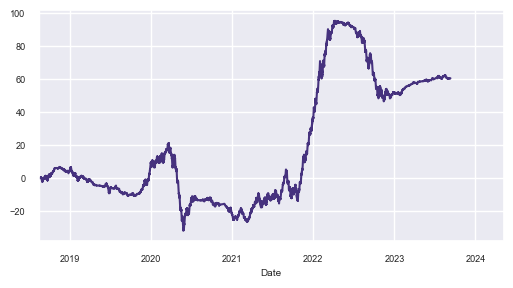

In [224]:
# EURUSD
out_of_sample_test(prices_hourly.iloc[:, 0], train_portion = 0.6, order = 2, num_days = 10*24, ptsl = [0.5, 0.5], span = 100*24)

Length of test: 50282


,close,returns,vert_bars,stop_loss,profit_taking,end_time,position,end_close,profit,outcome
Date,,,,,,,,,,
2018-08-12 10:00:00,1.27695,-0.001197,2019-04-09 10:00:00,2018-08-12 21:00:00,2018-08-13 12:00:00,2018-08-12 21:00:00,-1,1.30859,-0.024778,0.0
2018-08-12 11:00:00,1.27695,-0.000747,2019-04-09 11:00:00,2018-08-12 21:00:00,2018-08-13 12:00:00,2018-08-12 21:00:00,-1,1.30572,-0.022530,0.0
2018-08-12 12:00:00,1.27695,0.000101,2019-04-09 12:00:00,2018-08-12 21:00:00,2018-08-13 12:00:00,2018-08-12 21:00:00,-1,1.30558,-0.022421,0.0
2018-08-12 13:00:00,1.27695,-0.000467,2019-04-09 13:00:00,2018-08-12 21:00:00,2018-08-13 12:00:00,2018-08-12 21:00:00,-1,1.30578,-0.022577,0.0
2018-08-12 14:00:00,1.27695,-0.000966,2019-04-09 14:00:00,2018-08-12 21:00:00,2018-08-13 12:00:00,2018-08-12 21:00:00,-1,1.30457,-0.021630,0.0


OOS Sharpe: 2.0134197106929395, OOS Max drawdown: 35.2832559002493


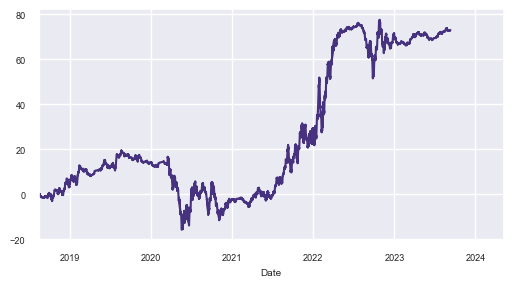

In [221]:
# GBPUSD
out_of_sample_test(prices_hourly.iloc[:, 1], train_portion = 0.6, order = 2, num_days = 10*24, ptsl = [0.5, 0.5], span = 100*24)

Length of test: 50282


,close,returns,vert_bars,stop_loss,profit_taking,end_time,position,end_close,profit,outcome
Date,,,,,,,,,,
2018-08-12 10:00:00,110.806,0.000338,2019-04-09 10:00:00,2018-08-12 21:00:00,2018-08-13 13:00:00,2018-08-12 21:00:00,-1,111.283,-0.004305,0.0
2018-08-12 11:00:00,110.806,-0.001325,2019-04-09 11:00:00,2018-08-12 21:00:00,2018-08-13 13:00:00,2018-08-12 21:00:00,-1,111.347,-0.004882,0.0
2018-08-12 12:00:00,110.806,0.000125,2019-04-09 12:00:00,2018-08-12 21:00:00,2018-08-13 13:00:00,2018-08-12 21:00:00,-1,111.077,-0.002446,0.0
2018-08-12 13:00:00,110.806,0.000365,2019-04-09 13:00:00,2018-08-12 21:00:00,2018-08-13 13:00:00,2018-08-12 21:00:00,-1,111.089,-0.002554,0.0
2018-08-12 14:00:00,110.806,0.002055,2019-04-09 14:00:00,2018-08-12 21:00:00,2018-08-13 13:00:00,2018-08-12 21:00:00,-1,111.118,-0.002816,0.0


OOS Sharpe: 3.482391728572781, OOS Max drawdown: 48.45635574321226


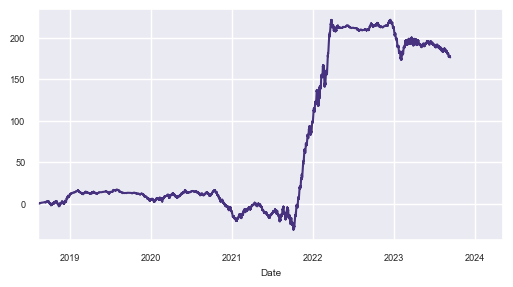

In [222]:
# USDJPY
out_of_sample_test(prices_hourly.iloc[:, 2], train_portion = 0.6, order = 2, num_days = 10*24, ptsl = [0.5, 0.5], span = 100*24)

<div class="alert alert-danger">

**for hourly data:      
 ~ sharpe = 1.7 - 3.5,         
 ~ max dd 35 - 55%**

</div>

#
 
<div class="alert alert-info">

**[collapse] MODEL FITTING**

</div>

In [21]:
target_meta = df['outcome_w_metalabels']

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

X_train_meta, X_test_meta, y_train_meta, y_test_meta = train_test_split(features_scaled, target_meta, test_size=0.2, random_state=404)

KeyError: "['outcome_w_metalabels'] not found in axis"

will delete later: split data by half for a quick trial run

In [ ]:
dfcut = df.iloc[int(len(df)/2):, :]
features = dfcut.drop(columns=['position', 'outcome', 'outcome_w_metalabels'])
target_meta = dfcut['outcome_w_metalabels']

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

### H2O

In [ ]:
h2o.init(max_mem_size = "2G")

combined_df = pd.DataFrame(features_scaled, columns=features.columns)
combined_df['outcome_w_metalabels'] = target_meta.values
h2o_df = h2o.H2OFrame(combined_df)
train, test = h2o_df.split_frame(ratios=[.8], seed=1234)
x = train.columns[:-1]
y = 'outcome_w_metalabels'
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()
print(f'Train/test length: {len(train), len(test)}')

aml = H2OAutoML(max_models=2, seed=404)
aml.train(x=x, y=y, training_frame=train)

lb = h2o.automl.get_leaderboard(aml, extra_columns="ALL")
lb_df = lb.as_data_frame()

all_preds = {}
for model_id in lb_df['model_id']:
    model = h2o.get_model(model_id)
    preds = model.predict(test)
    all_preds[model_id] = preds.as_data_frame()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.421-b09, mixed mode)
  Starting server from C:\Users\Kalulu\AppData\Local\Programs\Python\Python311\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\Kalulu\AppData\Local\Temp\tmpkzez5bna
  JVM stdout: C:\Users\Kalulu\AppData\Local\Temp\tmpkzez5bna\h2o_Kalulu_started_from_python.out
  JVM stderr: C:\Users\Kalulu\AppData\Local\Temp\tmpkzez5bna\h2o_Kalulu_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,05 secs
H2O_cluster_timezone:,Asia/Bangkok
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.4
H2O_cluster_version_age:,24 days
H2O_cluster_name:,H2O_from_python_Kalulu_1w5x3p
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.764 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Train/test length: (40470, 10071)
AutoML progress: |
13:47:08.644: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


h20 xgboost is not available on window 

In [ ]:
lb_df

NameError: name 'lb_df' is not defined

In [ ]:
gbm_results = all_preds['GBM_1_AutoML_1_20240803_134708']
gbm_results['predict'].value_counts() 

predict
1    5368
0    4703
Name: count, dtype: int64

In [ ]:
test

close,returns,sma_10,sma_20,sma_100,ema_10,ema_20,ema_100,z-score,roc_10,roc_20,roc_100,bb_upper,bb_middle,bb_lower,rsi_10,rsi_20,rsi_100,log_macd_hist,log_dpo,gmm_state_0,gmm_state_1,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,frac_diff_log,volat,outcome_w_metalabels
-0.90511,-1.42706,-0.92388,-0.92828,-0.946386,-0.918814,-0.924206,-0.950972,-1.00526,0.251333,0.521431,0.646326,-0.937658,-0.92828,-0.917702,0.493196,0.382857,0.688054,0.535873,0.255412,-0.0528361,0.0528361,-0.90979,-0.914642,-0.90561,-0.924521,-0.950547,-0.930581,-0.921709,-0.924996,-0.94912,-0.918055,-0.916309,-0.905016,-0.903132,-0.909413,-0.687138,-0.355501,1
-0.899383,0.251357,-0.900809,-0.91293,-0.940176,-0.903259,-0.911606,-0.944899,0.424744,0.488242,0.141591,0.686693,-0.92895,-0.91293,-0.895781,0.431009,0.401293,0.711118,0.385304,0.528465,-0.110511,0.110511,-0.89712,-0.897286,-0.896758,-0.893628,-0.886853,-0.905068,-0.909734,-0.914583,-0.905558,-0.924477,-0.950499,-0.930527,-0.921702,-0.925032,-0.72257,-0.4165,1
-0.959781,-0.0427553,-0.9198,-0.918929,-0.937366,-0.930505,-0.924654,-0.944893,0.256032,-1.42039,-0.155401,0.261012,-0.92608,-0.918929,-0.910576,-0.967177,-0.61703,0.194902,-1.27079,0.103568,-0.112111,0.112111,-0.959254,-0.927311,-0.942404,-0.923132,-0.899349,-0.897085,-0.897238,-0.896707,-0.893583,-0.886816,-0.905028,-0.909701,-0.914587,-0.905594,-0.987445,-0.456314,1
-1.00126,-0.579148,-0.94308,-0.926083,-0.936615,-0.951868,-0.937983,-0.946709,-0.221606,-2.02588,-1.01881,-0.0313368,-0.914623,-0.926083,-0.936192,-1.31482,-1.04508,-0.128911,-1.80872,-0.707903,-0.104202,0.104202,-0.977651,-0.941543,-0.959759,-0.959232,-0.927291,-0.942383,-0.923098,-0.89931,-0.897054,-0.897229,-0.896698,-0.893561,-0.886819,-0.905074,-1.20229,-0.349466,1
-1.02105,-0.0954012,-0.955475,-0.929608,-0.936841,-0.964505,-0.945951,-0.948226,0.19508,-2.41435,-1.0174,-0.170784,-0.905901,-0.929608,-0.951867,-1.51913,-1.24964,-0.273968,-2.18837,-1.12765,-0.111963,0.111963,-1.00125,-0.977643,-0.941536,-0.959753,-0.959225,-0.927283,-0.942362,-0.923087,-0.89931,-0.897055,-0.897218,-0.896685,-0.893587,-0.88685,-1.26802,-0.268272,1
-1.04587,-0.253263,-0.970126,-0.935677,-0.937316,-0.979358,-0.955525,-0.950207,0.00397166,-2.85387,-1.74703,-0.345704,-0.896137,-0.935677,-0.973643,-1.73339,-1.48005,-0.450759,-2.59914,-1.53324,-0.110727,0.110727,-1.02104,-1.00125,-0.977636,-0.941529,-0.959746,-0.959218,-0.927263,-0.942352,-0.923087,-0.899311,-0.897045,-0.897206,-0.896711,-0.893619,-1.36977,-0.205165,1
-1.04934,-0.758567,-0.982747,-0.942865,-0.937826,-0.992141,-0.964519,-0.952217,-0.388361,-2.4617,-2.06679,-0.370168,-0.891635,-0.942865,-0.992424,-1.76126,-1.51075,-0.47513,-2.7463,-1.88448,-0.0980563,0.0980563,-1.04586,-1.02103,-1.00124,-0.977629,-0.941523,-0.959738,-0.959197,-0.927252,-0.942351,-0.923088,-0.899301,-0.897032,-0.897232,-0.896743,-1.31142,-0.102075,1
-1.01914,0.989413,-0.99042,-0.948092,-0.938032,-0.997108,-0.969778,-0.953587,1.08591,-1.49912,-1.50421,-0.157328,-0.892441,-0.948092,-1.00203,-0.927029,-0.957717,-0.242085,-2.30977,-2.07554,-0.0858206,0.0858206,-1.04933,-1.04585,-1.02102,-1.00123,-0.977622,-0.941515,-0.959717,-0.959186,-0.927252,-0.942353,-0.923078,-0.899288,-0.897058,-0.897264,-1.05539,-0.0524798,1
-1.03163,-2.01751,-1.02387,-0.978495,-0.93911,-1.01389,-0.990457,-0.96016,-1.71724,-1.05749,-1.93875,-0.2454,-0.926336,-0.978495,-1.02893,-0.82963,-0.919856,-0.317636,-0.792821,-2.25434,0.038803,-0.038803,-1.02833,-1.03821,-0.99881,-1.00297,-1.0191,-1.04929,-1.0458,-1.02097,-1.00119,-0.977584,-0.941474,-0.959684,-0.959189,-0.927289,-1.13731,0.148809,1
-1.02608,0.398154,-1.0247,-0.997638,-0.939923,-1.01932,-0.999714,-0.9641,0.285645,0.38589,-1.82192,-0.206257,-0.967417,-0.997638,-1.02627,-0.678781,-0.819203,-0.275315,-0.0885674,-1.59228,-0.10813,0.10813,-1.02555,-1.02485,-1.03161,-1.02831,-1.03819,-0.998788,-1.00293,-1.01906,-1.04926,-1.04579,-1.02096,-1.00116,-0.977585,-0.94152,-1.0809,0.320719,1


In [ ]:
def predictions_to_profit(
    predicted_outcomes: np.ndarray,
    
)   

In [ ]:
results = []

for model_id in lb.as_data_frame()['model_id']:
    model = h2o.get_model(model_id)
    preddd = model.predict(test)
    
    preddd_df = preddd.as_data_frame()
    actuals = test[y].as_data_frame()
    
    accuracy = accuracy_score(actuals, preddd_df['predict'])
    
    returns = preddd_df['predict'].astype(float).values  # Assuming returns are in the 'predict' column
    sharpe_ratio_value = sharpe_ratio(returns)
    max_drawdown_value = max_drawdown(returns)
    
    results.append({
        'model_id': model_id,
        'accuracy': accuracy,
        'sharpe_ratio': sharpe_ratio_value,
        'max_drawdown': max_drawdown_value
    })
results_df = pd.DataFrame(results)
results_df

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
                                            model_id  accuracy  sharpe_ratio  \
0                      GBM_1_AutoML_4_20240730_11540  0.901797     70.066398   
1  StackedEnsemble_BestOfFamily_1_AutoML_4_202407...  0.946242     83.411855   
2                      GLM_1_AutoML_4_20240730_11540  0.529902   1108.036100   

   max_drawdown  
0           NaN  
1           NaN  
2           NaN  


wrong sharpe, will fix soon

### TPOT

In [ ]:
meta = TPOTClassifier(generations = 3, population_size = 10, warm_start = True, verbosity = 2)
meta.fit(X_train_meta, y_train_meta)
print(meta.score(X_test_meta, y_test_meta))

print("\nBest Pipeline:\n")
print(meta.fitted_pipeline_)
meta.export('best_pipeline.py')

Optimization Progress:  32%|███▎      | 13/40 [28:53<46:38, 103.64s/pipeline] 

Exception ignored on calling ctypes callback function: <bound method DataIter._next_wrapper of <xgboost.data.SingleBatchInternalIter object at 0x0000027F099A0990>>
Traceback (most recent call last):
  File "c:\Users\Kalulu\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py", line 582, in _next_wrapper
    def _next_wrapper(self, this: None) -> int:  # pylint: disable=unused-argument

KeyboardInterrupt: 


Optimization Progress:  35%|███▌      | 14/40 [29:03<34:59, 80.77s/pipeline] 